In [152]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [153]:
# Download and save data
df = yf.download('ALI=F', start='2000-01-01', end='2025-01-01')
df = df.reset_index()
df.to_csv('aluminum_futures.csv', index=False)
df = df.drop(['Adj Close'], axis=1)

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


[*********************100%%**********************]  1 of 1 completed

Data shape: (2645, 6)

First few rows:
        Date     Open     High      Low    Close  Volume
0 2014-05-06  2182.75  2205.75  2165.00  2172.75      41
1 2014-05-07  2152.25  2152.25  2146.00  2149.00      35
2 2014-05-08  2150.00  2150.00  2130.00  2141.75      25
3 2014-05-09  2133.50  2133.50  2107.25  2107.25      14
4 2014-05-12  2086.00  2088.25  2086.00  2088.25       4


In [154]:
# Define TensorFlow PINN Model
input_dim = df.shape[1] - 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [155]:
# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df.iloc[:, 1:])

In [156]:
# Prepare training data
X = data_normalized[:-1]  # Current day's features
y = data_normalized[1:, 0:1]  # Next day's opening price

In [157]:
# Split data
train_end = int(0.7 * len(X))
val_end = int(0.85 * len(X))

X_train = X[:train_end]
y_train = y[:train_end]
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
X_test = X[val_end:]
y_test = y[val_end:]

In [158]:
alpha1 = 0.1
alpha2 = 0.1
alpha3 = 0.1
alpha4 = 0.7

In [159]:
# Add lists to track training and validation losses
training_losses = []
validation_losses = []

In [160]:
# Training setup
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

for epoch in range(1000):
    with tf.GradientTape() as tape:
        y_pred = model(tf.convert_to_tensor(X_train, dtype=tf.float32), training=True)

        pred_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, y_pred))

        open_price = X_train[:, 0]
        high_price = X_train[:, 1]
        low_price = X_train[:, 2]
        close_price = X_train[:, 3]
        volume = X_train[:, 4]

        momentum = tf.reduce_mean(tf.abs(y_pred[1:] - y_pred[:-1]))
        price_mean = (open_price + close_price) / 2
        mean_reversion = tf.reduce_mean(tf.abs(tf.squeeze(y_pred) - price_mean))
        price_change = tf.abs(tf.squeeze(y_pred) - close_price)
        volume_price = tf.reduce_mean(price_change / (volume + 1e-6))
        range_violation = tf.reduce_mean(
            tf.nn.relu(tf.squeeze(y_pred) - high_price) +
            tf.nn.relu(low_price - tf.squeeze(y_pred))
        )

        physics_loss = (
            alpha1 * momentum +
            alpha2 * mean_reversion +
            alpha3 * volume_price +
            alpha4 * range_violation
        )

        total_loss = pred_loss + physics_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Calculate validation loss
    val_pred = model(tf.convert_to_tensor(X_val, dtype=tf.float32), training=False)
    val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, val_pred))

    # Store losses
    training_losses.append(total_loss.numpy())
    validation_losses.append(val_loss.numpy())

    if (epoch + 1) % 100 == 0:
        val_pred = model(tf.convert_to_tensor(X_val, dtype=tf.float32), training=False)
        val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, val_pred))

        print(f'Epoch {epoch+1}:')
        print(f'  Total Loss: {total_loss.numpy():.6f}')
        print(f'  Prediction Loss: {pred_loss.numpy():.6f}')
        print(f'  Physics Loss: {physics_loss.numpy():.6f}')
        print(f'  Validation Loss: {val_loss.numpy():.6f}')


Epoch 100:
  Total Loss: 1372.786133
  Prediction Loss: 0.000611
  Physics Loss: 1372.785522
  Validation Loss: 0.004061
Epoch 200:
  Total Loss: 62.633076
  Prediction Loss: 0.000084
  Physics Loss: 62.632992
  Validation Loss: 0.000521
Epoch 300:
  Total Loss: 40.111038
  Prediction Loss: 0.000081
  Physics Loss: 40.110958
  Validation Loss: 0.000455
Epoch 400:
  Total Loss: 25.526897
  Prediction Loss: 0.000081
  Physics Loss: 25.526817
  Validation Loss: 0.000444
Epoch 500:
  Total Loss: 19.398958
  Prediction Loss: 0.000082
  Physics Loss: 19.398876
  Validation Loss: 0.000443
Epoch 600:
  Total Loss: 26.246511
  Prediction Loss: 0.000082
  Physics Loss: 26.246429
  Validation Loss: 0.000443
Epoch 700:
  Total Loss: 35.077328
  Prediction Loss: 0.000081
  Physics Loss: 35.077248
  Validation Loss: 0.000441
Epoch 800:
  Total Loss: 17.360971
  Prediction Loss: 0.000082
  Physics Loss: 17.360889
  Validation Loss: 0.000441
Epoch 900:
  Total Loss: 24.669956
  Prediction Loss: 0.0000

In [161]:
# Generate predictions
y_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32), training=False)

In [162]:
# Convert back to original scale
y_pred_orig = scaler.inverse_transform(
    np.concatenate([y_pred.numpy(), np.zeros((len(y_pred), 4))], axis=1)
)[:, 0]
y_test_orig = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((len(y_test), 4))], axis=1)
)[:, 0]

In [163]:
# Calculate metrics
mse = np.mean((y_pred_orig - y_test_orig) ** 2)
mae = np.mean(np.abs(y_pred_orig - y_test_orig))

# Calculate MAPE
nonzero_indices = y_test_orig != 0  # Avoid division by zero
mape = np.mean(np.abs((y_test_orig[nonzero_indices] - y_pred_orig[nonzero_indices]) / y_test_orig[nonzero_indices])) * 100

# Calculate directional accuracy
actual_direction = np.sign(np.diff(y_test_orig))
predicted_direction = np.sign(np.diff(y_pred_orig))

# Remove cases where actual direction is 0 (no change)
valid_indices = actual_direction != 0
actual_direction = actual_direction[valid_indices]
predicted_direction = predicted_direction[valid_indices]

directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

# Calculate separate accuracies for up and down movements
up_indices = actual_direction > 0
down_indices = actual_direction < 0

up_accuracy = np.mean(predicted_direction[up_indices] == actual_direction[up_indices]) * 100 if len(up_indices) > 0 else 0
down_accuracy = np.mean(predicted_direction[down_indices] == actual_direction[down_indices]) * 100 if len(down_indices) > 0 else 0

# Print results
print(f'\nTest Metrics:')
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'Directional Accuracy: {directional_accuracy:.2f}%')
print(f'Up Movement Accuracy: {up_accuracy:.2f}%')
print(f'Down Movement Accuracy: {down_accuracy:.2f}%')



Test Metrics:
MSE: 999.82
MAE: 23.70
MAPE: 1.01%
Directional Accuracy: 49.36%
Up Movement Accuracy: 44.26%
Down Movement Accuracy: 53.81%


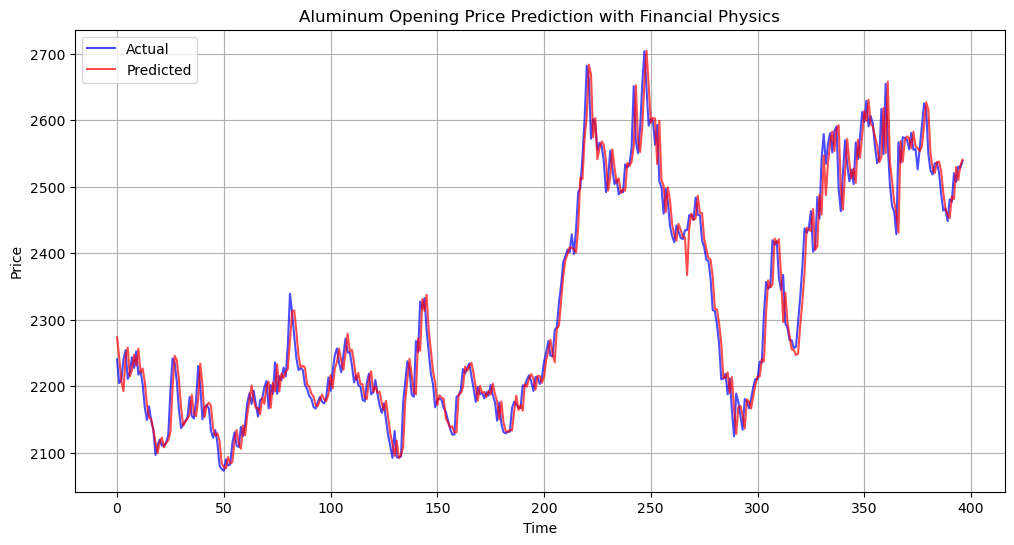

In [164]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_orig, label='Predicted', color='red', alpha=0.7)
plt.title('Aluminum Opening Price Prediction with Financial Physics')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

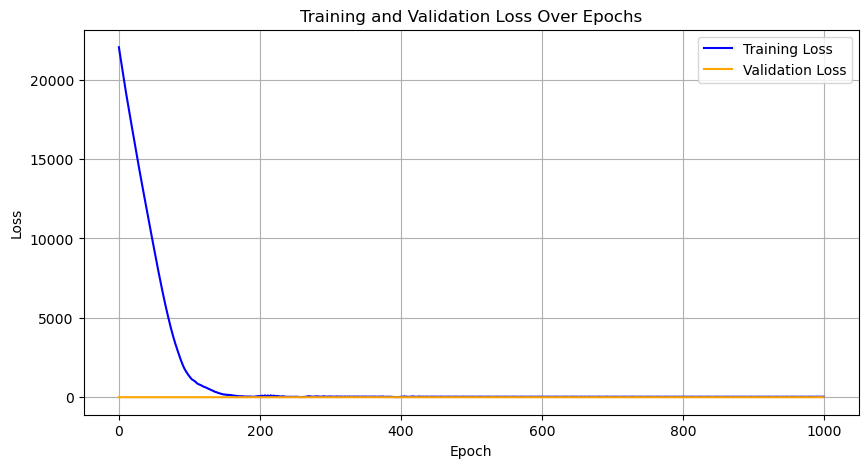

In [165]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss', color='blue')
plt.plot(validation_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()